# Imports 

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy

In [4]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
stop_words = set(stopwords.words('english'))
import re
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jaccard
from scipy.sparse import hstack
%matplotlib inline

In [5]:
from ekphrasis.classes.exmanager import ExManager
from ekphrasis.classes.spellcorrect import SpellCorrector

In [ ]:
from flair.data import Sentence
from flair.embeddings import WordEmbeddings

In [ ]:
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from keras.callbacks import Callback

In [44]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

In [32]:
EMBEDDING_DIM = 300 # how big is each word vector
VOCAB_SIZE = 20000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 100 # max number of words in a comment to use
seed = 42
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
n_classes = len(label_names)
path =  r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\laba-task3-toxic-comments'
regexes = ExManager().get_compiled()

# Auxillary functions

In [ ]:
def roc_auc(sub, y_test, n_classes=n_classes):

    y_score = sub.drop(test_labels[test_labels['toxic'] ==-1].index).iloc[:,1:]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score.iloc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.figure()
    lw = 2
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc-curves')
    plt.legend(loc="lower right")
    plt.show()
    
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
 
    def on_train_begin(self, logs={}):
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred, average='macro', sample_weight=None)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return

In [8]:
def handle_elongated_match(m):
    
    text = m.group()
    regexes = ExManager().get_compiled()
    text = regexes["normalize_elong"].sub(r'\1', text)

    return text


# разметка и нижний регистр
def cleaning(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df
# числа
def no_num(token_sents):
    
    list_of_sents = []
    sents = []
    for sent in token_sents:
        sents = []
        for token in sent:
            if token.isalpha():
                sents.append(token)
        list_of_sents.append(sents)
    return list_of_sents

def lemma(df):
    lem = WordNetLemmatizer()
    lemma_tokens = []
    for i in df['tokens'].values:
        tokens = [lem.lemmatize(word, "v") for word in i]
        lemma_tokens.append(tokens)
    return lemma_tokens

def full_preproc(df, text_field):
    temp_df = cleaning(df, text_field)
    temp_df[text_field] = temp_df[text_field].apply(lambda x: regexes["elongated"].sub(lambda w: handle_elongated_match(w), x))
    tokenizer = RegexpTokenizer(r'\w+')
    temp_df['tokens'] = temp_df[text_field].apply(tokenizer.tokenize)
    temp_df['tokens'] = temp_df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
    temp_df['tokens'] = no_num(temp_df['tokens'].values)
    temp_df['lemma_tokens'] = lemma(temp_df)
    return temp_df

In [9]:
def model(x_t, y_t, x_v, y_v, embd_w):
    inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = Embedding(VOCAB_SIZE, 
                  EMBEDDING_DIM,
                  weights=[embd_w])(inp)
    x = Bidirectional(LSTM(50, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam')
    
    model.fit(x_t,
          y_t,
          validation_data=(x_v, y_v),
          callbacks=[roc_callback(training_data=(x_t, y_t), validation_data=(x_v, y_v))], 
                     batch_size=64, 
                     epochs=2, 
                     verbose=1
         )
    return model

def pred_and_sub(inp_model):
    y_test = inp_model.predict(padded_test_data, batch_size=1024, verbose=1)
    submission_df = pd.DataFrame(columns=['id'] + label_names)
    submission_df['id'] = data_test['id'].values 
    submission_df[label_names] = y_test 
    submission_df.to_csv("./submission.csv", index=False)
    return submission_df

# Data loading

In [12]:
data_train = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba-task3-toxic-comments\train.csv')
data_train = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba-task3-toxic-comments\train.csv')
data_test = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba-task3-toxic-comments\test.csv')
test_labels = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba-task3-toxic-comments\test_labels.csv')
#sample_submission = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\sample_submission.csv')

In [13]:
y = data_train[label_names]
y_test = test_labels[test_labels['toxic'] !=-1].iloc[:,1:]

# EDA

In [10]:
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Псмотрим сколько всего нетоксичных и всяких токсичных комментов 

In [11]:
x = data_train.iloc[:,2:].sum()
rowsums=data_train.iloc[:,2:].sum(axis=1)
print("Total comments ",data_train.shape[0])
print("Nomber of non-toxic comments",list(pd.DataFrame(rowsums==0).sum())[0])
print("Total toxic ",x.sum())

Total comments  159571
Nomber of non-toxic comments 143346
Total toxic  35098


Получается у нас топик может быть разнообразно токсичен (то есть и угроза и обзывательство и тд). Посмотрим как распределены комменты по различным токсичностям.

In [12]:
col_names = data_train.columns.values[2:]
col_names = col_names.tolist()
col_names.append('None')
x = [sum(data_train[y]) for y in data_train.columns.values[2:]]
x.append(len(data_train) - sum(x))

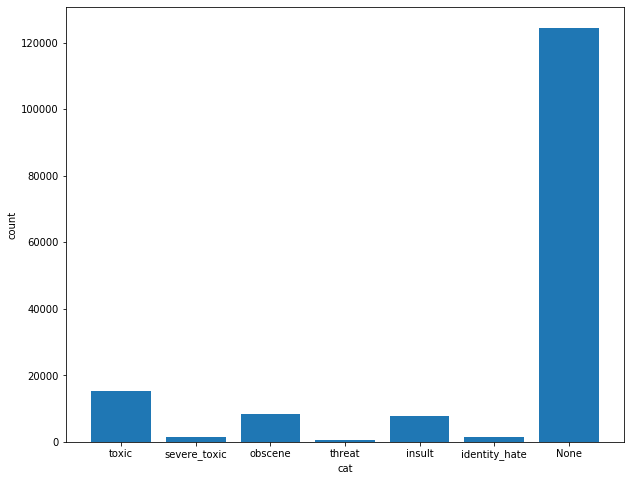

In [13]:
plt.figure(figsize = (10, 8))
plt.bar(np.arange(len(x)),x)
plt.xticks(np.arange(len(x)), col_names)
plt.xlabel('cat')
plt.ylabel('count')
plt.show()

Классы сильно несбалансированы. Еще можно посмотреть на количество текстов с миксом токсик тэгов

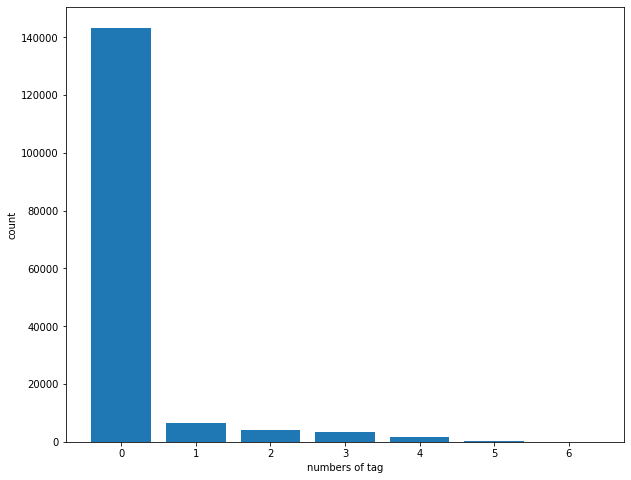

In [14]:
x=rowsums.value_counts()
plt.figure(figsize = (10, 8))
plt.bar(np.arange(len(x)),x)
plt.xticks(np.arange(len(x)))
plt.xlabel('numbers of tag')
plt.ylabel('count')
plt.show()

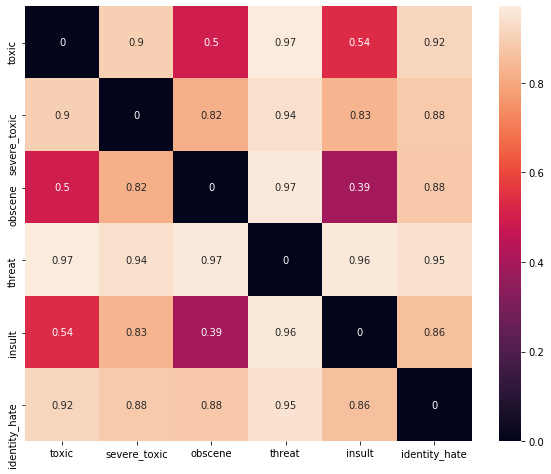

In [31]:
corr = pd.DataFrame(columns = temp_df.columns, index = temp_df.columns)
for i in range(len(corr.columns)):
    corr[corr.columns[i]] = [jaccard(temp_df[corr.columns[i]].values, temp_df[corr.columns[j]].values) for j in range(len(corr.columns))]
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)    

In [250]:
text_lens = []
for text in tqdm(data_train['lemma_tokens']):
        text_lens.append(len(text))


100%|█████████████████████████████████████████████████████████████████████████| 159571/159571 [00:00<00:00, 2070615.79it/s]


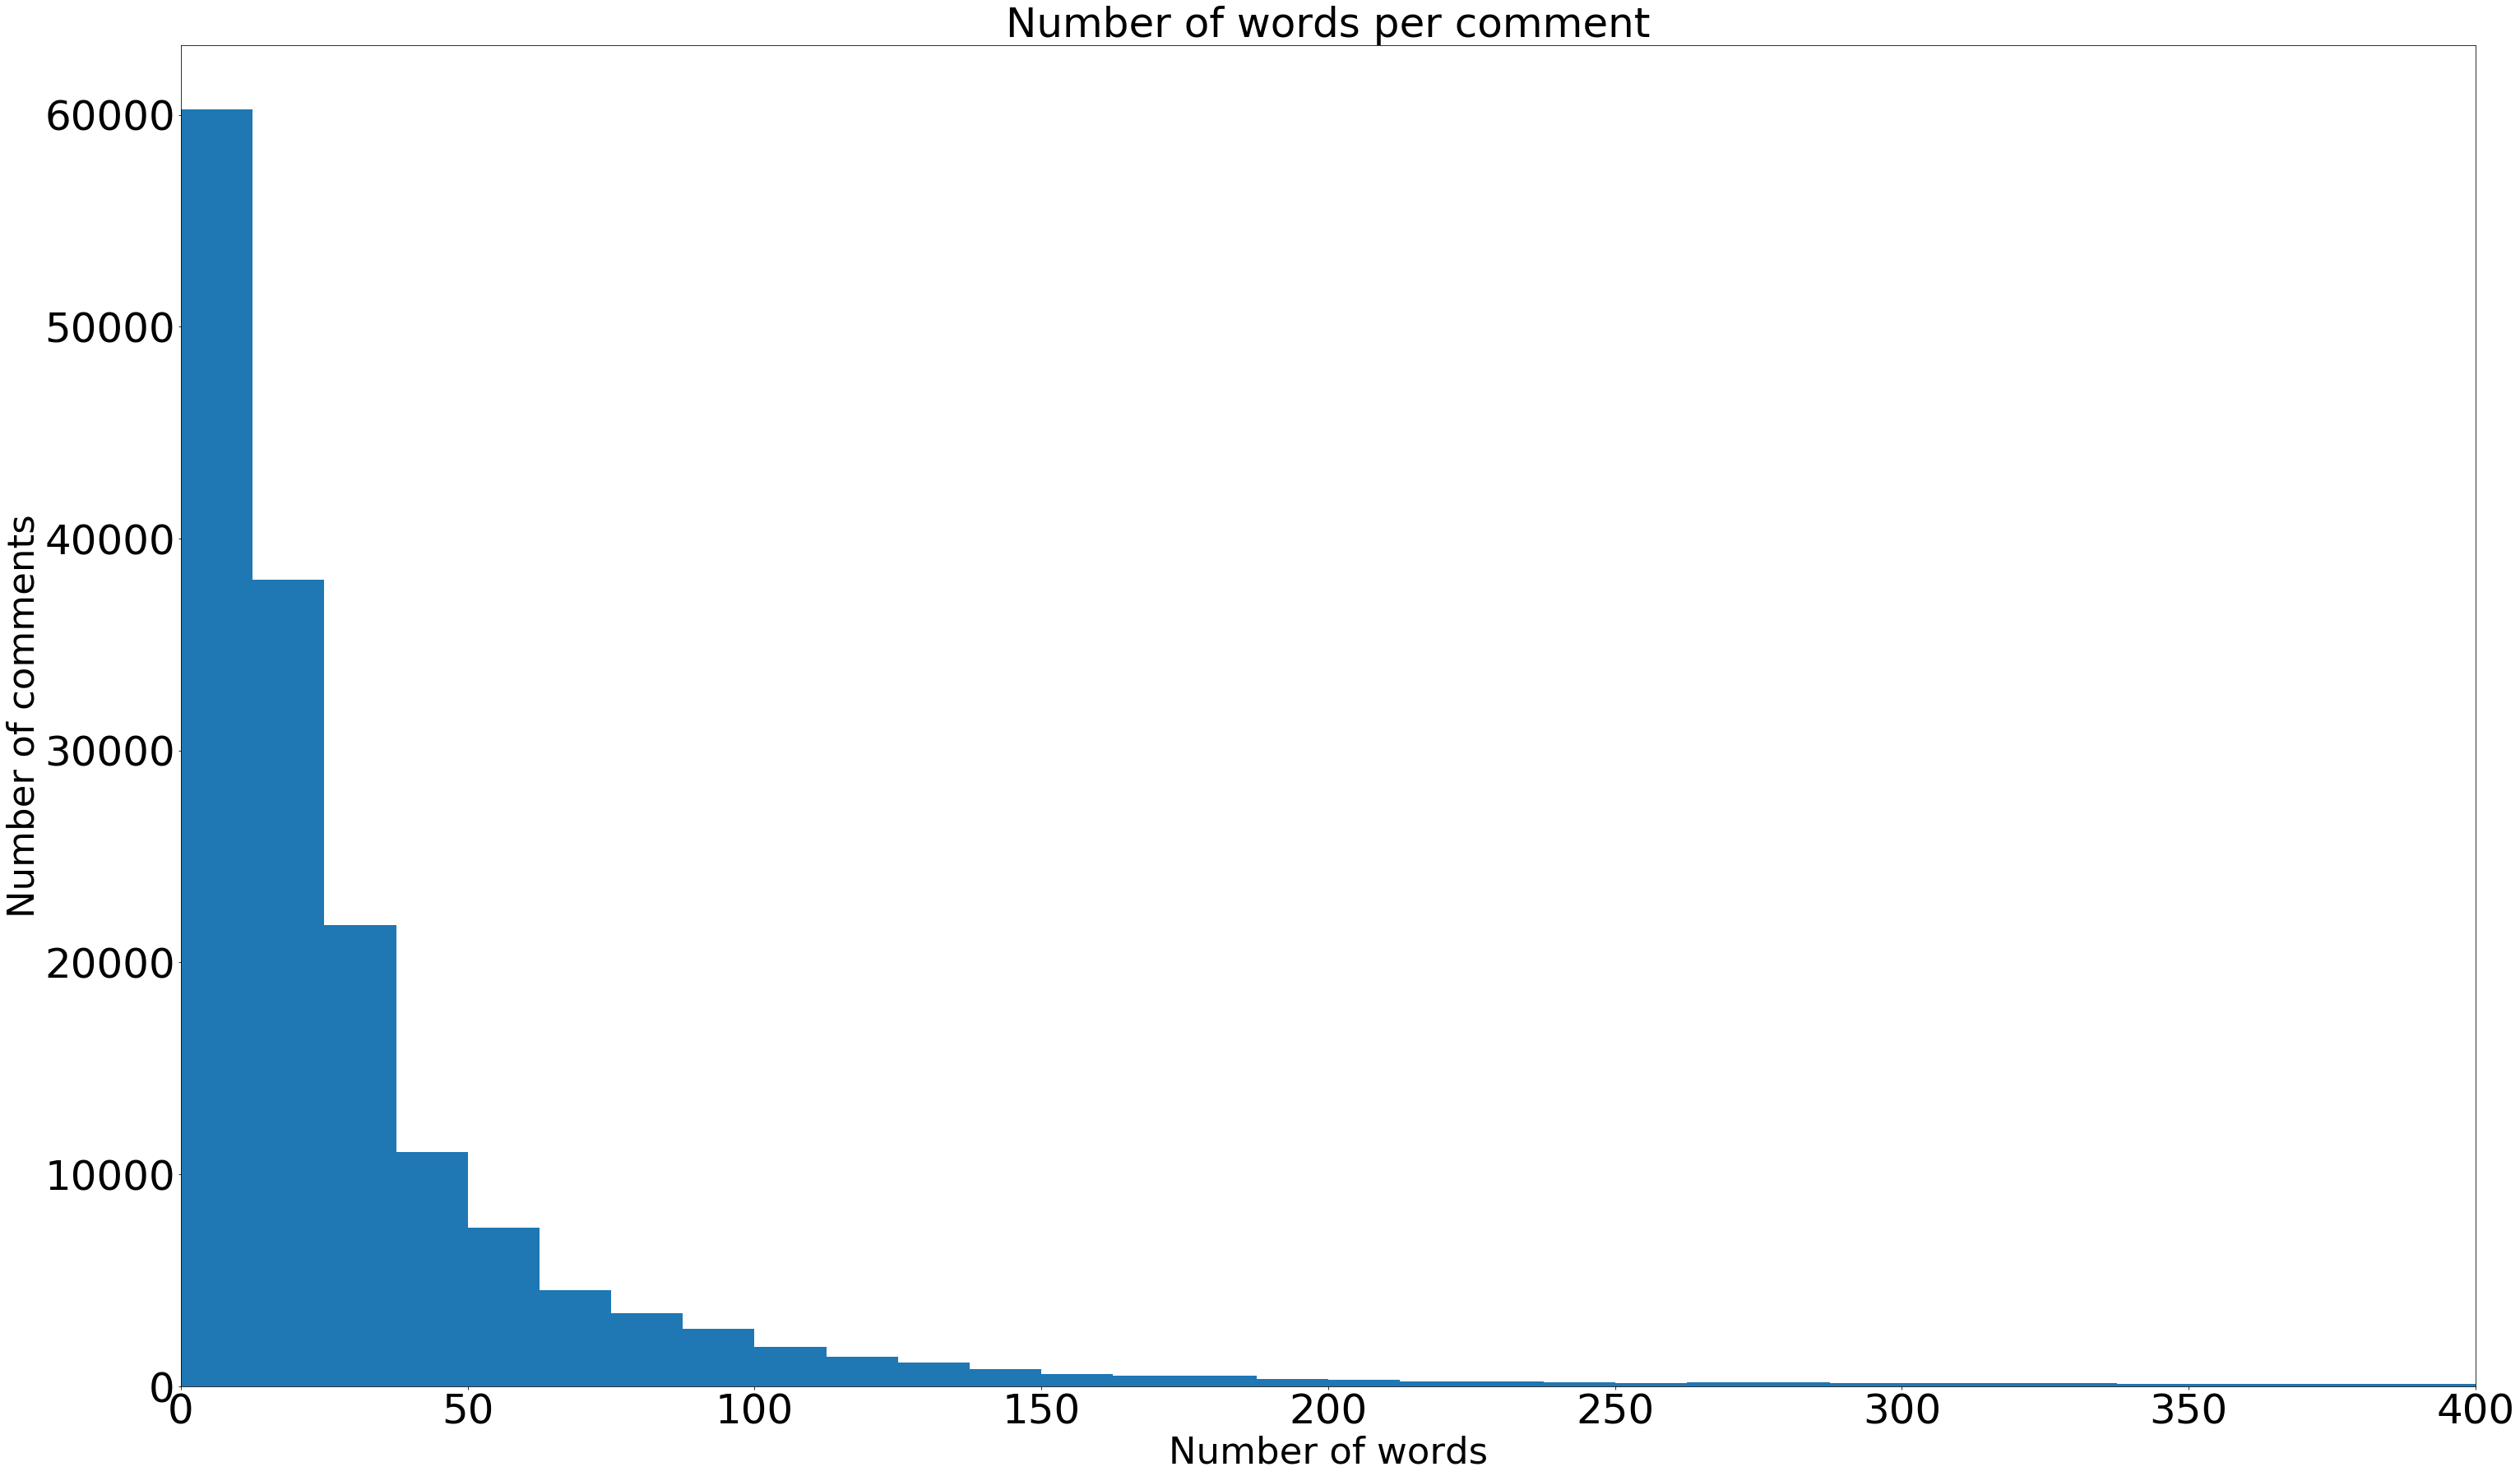

In [265]:
f = plt.figure(figsize=(50, 30))
plt.axes()
f.gca().set_xlim((0, 400))
plt.hist(text_lens, bins= 100)
plt.tick_params(axis='both', which='major', labelsize=50)

plt.title('Number of words per comment', fontsize=50)
plt.xlabel('Number of words', fontsize=45)
plt.ylabel('Number of comments', fontsize=45)
plt.show()

In [257]:
np.median(text_lens)

18.0

In [258]:
np.mean(text_lens)

34.0266025781627

# Preprocessing

In [24]:
#data_train = full_preproc(data_train, 'comment_text')
#data_test = full_preproc(data_test, 'comment_text')
#with open('./data_train.p', 'wb') as f:
    #pickle.dump(data_train, f)
#with open('./data_test.p', 'wb') as f:
 #   pickle.dump(data_test, f)
data_train = pickle.load(open('./data_train.p', "rb" ))
data_test = pickle.load(open('./data_test_toxic.p', "rb"))

In [23]:
data_train = data_train.drop(data_train[data_train['lemma_tokens_sents'] == ''].index, axis=0)
data_train = data_train.reset_index(drop=True)

In [22]:
data_train['comment_text'] = data_train['comment_text'].apply(lambda x: x.replace('\n', ' '))

In [25]:
data_train['lemma_tokens_sents'] = data_train['lemma_tokens'].apply(lambda x: ' '.join(x))
data_test['lemma_tokens_sents'] = data_test['lemma_tokens'].apply(lambda x: ' '.join(x))

In [25]:
words = [word for tokens in data_train['tokens'] for word in tokens]
vocab = set(words)
vocab_size = len(vocab)
print('Vocabulary size', vocab_size)

Vocabulary size 160815


In [26]:
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens,lemma_tokens,lemma_tokens_sents
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,"[explanation, edits, made, username, hardcore,...","[explanation, edit, make, username, hardcore, ...",explanation edit make username hardcore metall...
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,"[aww, matches, background, colour, seemingly, ...","[aww, match, background, colour, seemingly, st...",aww match background colour seemingly stick th...
2,000113f07ec002fd,"hey man, i'm really not trying to edit war it...",0,0,0,0,0,0,"[hey, man, really, trying, edit, war, guy, con...","[hey, man, really, try, edit, war, guy, consta...",hey man really try edit war guy constantly rem...
3,0001b41b1c6bb37e,""" more i can't make any real suggestions on im...",0,0,0,0,0,0,"[make, real, suggestions, improvement, wondere...","[make, real, suggestions, improvement, wonder,...",make real suggestions improvement wonder secti...
4,0001d958c54c6e35,"you, sir, are my hero any chance you remember...",0,0,0,0,0,0,"[sir, hero, chance, remember, page]","[sir, hero, chance, remember, page]",sir hero chance remember page


### TF-IDF LogReg baseline

Baseline LogReg model based on word-gramms and char-gramms 

In [27]:
n = data_train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, 
               strip_accents='unicode', 
               use_idf=1,
               smooth_idf=1, 
               sublinear_tf=1,
               max_features=10000)
trn_term_doc = vec.fit_transform(data_train['lemma_tokens_sents'])
test_word_features  = vec.transform(data_test['lemma_tokens_sents'])

In [28]:
char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(2, 6),
    max_features=50000)
trn__char_term_doc = char_vectorizer.fit_transform(data_train['lemma_tokens_sents'])
test_char_features = char_vectorizer.transform(data_test['lemma_tokens_sents'])

In [29]:
train_features = hstack([trn__char_term_doc, trn_term_doc])
test_features = hstack([test_char_features, test_word_features])

In [30]:
scores = []
submission = pd.DataFrame.from_dict({'id': data_test['id']})
for class_name in label_names:
    train_target = data_train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('Score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total score is {}'.format(np.mean(scores)))

Score for class toxic is 0.9649524236146862
Score for class severe_toxic is 0.9859377725722792
Score for class obscene is 0.9844914596194535
Score for class threat is 0.9732081658473004
Score for class insult is 0.974247381419738
Score for class identity_hate is 0.9738331462344689
Total score is 0.9761117248846544


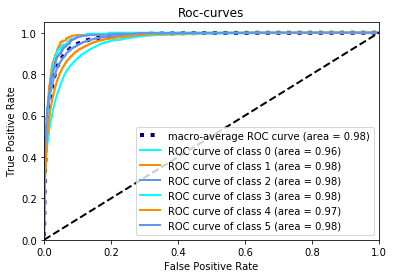

In [99]:
roc(submission, y_test)

### Загружаем предобученный W2V

In [26]:
w2v_path = path + '\GoogleNews-vectors-negative300.bin.gz'
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)

С помощью keras tokenizer создаем индексированный словарь и предложения в виде последовательности индексов.

In [30]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=False, char_level=False)

tokenizer.fit_on_texts(data_train['lemma_tokens_sents'].tolist())

training_sequences = tokenizer.texts_to_sequences(data_train['lemma_tokens_sents'].tolist())
test_sequences = tokenizer.texts_to_sequences(data_test['lemma_tokens_sents'].tolist())

Обрезаем слишком длинные комментарии и добавляем паддинги в короткие.

In [31]:
padded_train_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [32]:
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 148128 unique tokens.


In [34]:
X_train, X_val, y_train, y_val = train_test_split(padded_train_data, y, test_size=0.2, random_state=seed)

# W2V

In [69]:
train_embedding_weights = np.zeros((len(list(train_word_index.items())[:20000]), EMBEDDING_DIM))
for word,index in list(train_word_index.items())[:19999]:
    if word in w2v:
        train_embedding_weights[index,:] = w2v[word]  
print(train_embedding_weights.shape)

(20000, 300)


In [ ]:
model = model(X_train, y_train, X_val, y_val, train_embedding_weights)

In [39]:
pred_and_sub(model)
# 0.97782
# 0.97789 после удаления слов с большим повторением букв


153164/153164 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 35 - ETA: 35 - 

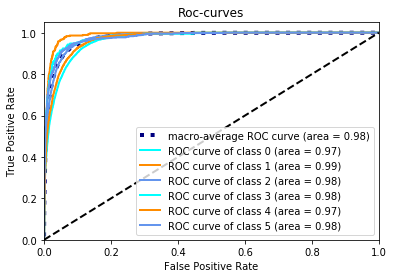

In [105]:
roc(pred_and_sub, y_test)

Максро скор слегка увеличился, на десятую увеличились скоры по первым двум классам.

# Glove

In [44]:
embeddings_index = {}
with io.open(path+'\glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [47]:
train_glove_embedding_weights = np.zeros((len(list(train_word_index.items())[:20000]), EMBEDDING_DIM))
temp = 0
for word,index in list(train_word_index.items())[:19999]:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        train_glove_embedding_weights[index] = embedding_vector
print(train_glove_embedding_weights.shape)

(20000, 300)


In [ ]:
model_glove = model(X_train, y_train, X_val, y_val, train_glove_embedding_weights)

In [55]:
pred_and_sub(model_glove)
# 0.97807 после удаления слов с большим повторением букв 

153164/153164 [==============================] - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - E

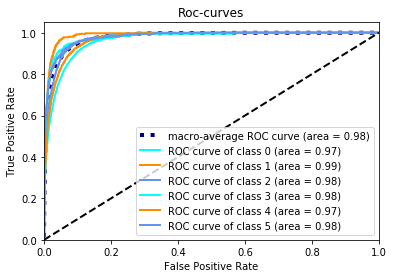

In [107]:
roc(pred_and_sub, y_test)

Так же слегка увеличился скор

# Flair fasttext

In [ ]:
train_ft_embedding_weights = np.zeros((len(list(train_word_index.items())[:20000]), EMBEDDING_DIM))
for word,index in list(train_word_index.items())[:19999]:
    embedding_vector = ft_embedding.get_cached_vec(word)
        # words not found in embedding index will be all-zeros.
    train_ft_embedding_weights[index] = np.array(embedding_vector)
print(train_ft_embedding_weights.shape)

In [ ]:
model_ft = model(X_train, y_train, X_val, y_val, train_ft_embedding_weights)

In [67]:
pred_and_sub(model_ft)
# 0.97702

153164/153164 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - 

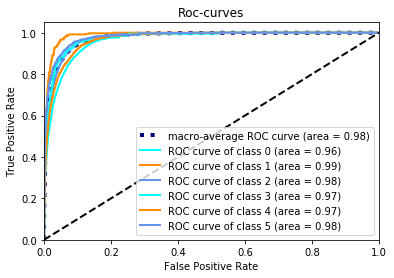

In [109]:
roc(pred_and_sub, y_test)

С Fasttext эмбеддингами результат получился хуже чем с w2v и Glove.

# Flair bert

https://medium.com/swlh/painless-fine-tuning-of-bert-in-pytorch-b91c14912caa

In [111]:
from transformers import BertModel
import torch
from transformers import DistilBertModel, BertTokenizer

In [113]:
#Creating instance of BertModel
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [136]:
#Creating intance of tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#Specifying the max length
T = 12

In [137]:
sentence = 'I really enjoyed this movie a lot.'

In [138]:
#Step 1: Tokenize
tokens = tokenizer.tokenize(sentence)
#Step 2: Add [CLS] and [SEP]
tokens = ['[CLS]'] + tokens + ['[SEP]']

In [139]:
padded_tokens = tokens + ['[PAD]' for _ in range(T - len(tokens))]
attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]

In [140]:
token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

In [141]:
seg_ids = [0 for _ in range(len(padded_tokens))] #Optional!

In [142]:
token_ids = torch.tensor(token_ids).unsqueeze(0) #Shape : [1, 12]
attn_mask = torch.tensor(attn_mask).unsqueeze(0) #Shape : [1, 12]
seg_ids   = torch.tensor(seg_ids).unsqueeze(0)

In [144]:
#Converting everything to torch tensors before feeding them to bert_model
token_ids = torch.tensor(token_ids).unsqueeze(0) #Shape : [1, 12]
attn_mask = torch.tensor(attn_mask).unsqueeze(0) #Shape : [1, 12]
seg_ids   = torch.tensor(seg_ids).unsqueeze(0) #Shape : [1, 12]

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd

In [129]:
#Feed them to bert
hidden_reps, cls_head = bert_model(token_ids, attention_mask = attn_mask,\
                                  token_type_ids = seg_ids)
print(hidden_reps.shape)
#Out: torch.Size([1, 12, 768])
print(cls_head.shape)
#Out: torch.Size([1, 768])

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [54]:
import tensorflow as tf
import keras as keras
import keras.backend as K
from keras.models import load_model

from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

In [ ]:
SEQ_LEN = 64
BATCH_SIZE = 128
EPOCHS = 1
LR = 1e-4

pretrained_path = '../input/pretrained-bert-including-scripts/uncased_l-12_h-768_a-12/uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = 'comment_text'
LABEL_COLUMN = 'target'

In [60]:
from transformers import BertForSequenceClassification
NUM_LABELS = 6  # For paraphrase identification, labels are binary, "paraphrase" or "not paraphrase".
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS)

In [30]:
def preprocess(tokenizer: BertTokenizer, text):
    
    # Use BertTokenizer to encode (tokenize / indexize) two sentences.
    tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            )
    
    # Output of `tokenizer.encode_plus` is a dictionary.
    input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]
    # For BERT, we need `attention_mask` along with `input_ids` as input.
    attention_mask = [1] * len(input_ids)
    # We are going to pad sequences.
    padding_length = MAX_LEN - len(input_ids)
    pad_id = tokenizer.pad_token_id
    input_ids = input_ids + ([pad_id] * padding_length)
    attention_mask = attention_mask + ([0] * padding_length)
    token_type_ids = token_type_ids + ([pad_id] * padding_length)
    
    assert len(input_ids) == MAX_LEN, "Error with input length {} vs {}".format(len(input_ids), MAX_LEN)
    assert len(attention_mask) == MAX_LEN, "Error with input length {} vs {}".format(len(attention_mask), MAX_LEN)
    assert len(token_type_ids) == MAX_LEN, "Error with input length {} vs {}".format(len(token_type_ids), MAX_LEN)
    return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids
            }